# Gaussian Process Regression

### Hartmann Flow

Hartmann Flow is a flow phenomenon that occurs when Poiseuille Flow occurs in presence of a magnetic field where the fluid is susceptible to the magnetic field. Due to the voltage and subsequent current induced in the fluid, the flow forms a particular shape that is highly non-linear in nature (more complex than the case of a Poiseuille Flow). The solution to the flow problem can be found online.

<body> <center> $\dfrac{u}{c} = \dfrac{1}{M^2}\Big(1 - \dfrac{\cosh My}{\cosh M}\Big)$ </center> </body>

where $y \in[-1,1]$ and $M$ is the Hartmann Number (a dimensionless quantity).

For the test problem, let $c = 50$, and $M = 7$. 

In [13]:
import numpy as np
import torch
import gpytorch
import matplotlib.pyplot as plt
%matplotlib inline

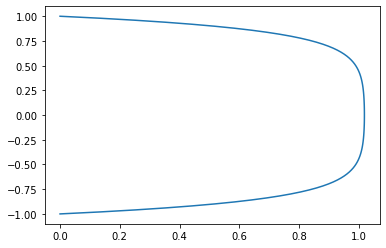

In [14]:
c = 50
M = 7
y = torch.linspace(-1,1, 100)
u = c/(M**2) * (1 - torch.cosh(M*y)/(torch.cosh(torch.Tensor([M]))))
plt.plot(u,y)

Now, instead of plotting a line, let us drop a number of points and then plot a scatter plot.

(-1.0, 1.0)

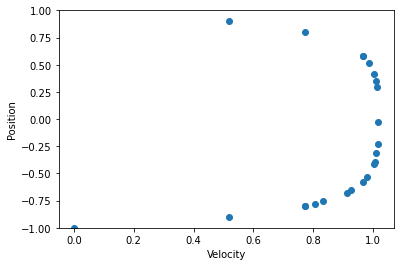

In [32]:
np.random.seed(7895)
y = torch.linspace(-1,1, 100)[np.random.randint(0,100,23)]
u = c/(M**2) * (1 - torch.cosh(M*y)/(torch.cosh(torch.Tensor([M]))))
plt.scatter(u,y)
plt.xlabel('Velocity')
plt.ylabel('Position')
plt.ylim([-1,1])

Here, ```train_x``` is $y$ and ```train_y``` is $u$.

In [33]:
train_x = y
train_y = u

In [34]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [35]:
for x in model.named_parameters():
    print(x)

('likelihood.noise_covar.raw_noise', Parameter containing:
tensor([0.], requires_grad=True))
('mean_module.constant', Parameter containing:
tensor([0.], requires_grad=True))
('covar_module.raw_outputscale', Parameter containing:
tensor(0., requires_grad=True))
('covar_module.base_kernel.raw_lengthscale', Parameter containing:
tensor([[0.]], requires_grad=True))


In [36]:
# Find optimal model hyperparameters
model.train()
likelihood.train()
training_iter = 500

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
#     print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
#         i + 1, training_iter, loss.item(),
#         model.covar_module.base_kernel.lengthscale.item(),
#         model.likelihood.noise.item()
#     ))
    optimizer.step()

In [37]:
model.eval()
likelihood.eval()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [39]:
test_x = torch.linspace(-1, 1 , 100)
f_pred = model(test_x)
y_pred = likelihood(model(test_x))

f_mean = f_pred.mean
f_var = f_pred.variance
f_covar = f_pred.covariance_matrix
f_samples = f_pred.sample(sample_shape=torch.Size([100]))

/Users/jaymehta/miniconda3/lib/python3.7/site-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 9.999999999999999e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", NumericalWarning)


In [40]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
#     test_x = torch.linspace(0, 1, 51)
    observed_pred = likelihood(model(test_x))

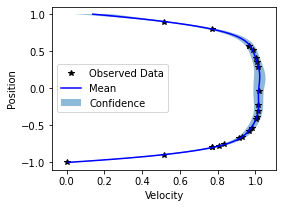

In [45]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_y.numpy(),train_x.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(observed_pred.mean.numpy(), test_x.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_betweenx(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
#     ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    ax.set_xlabel('Velocity')
    ax.set_ylabel('Position')

In sum, what we observe is that regardless of the complexity of the underlying model, Gaussian Process Regression manages to fit the data, and also provides confidence intervals, which makes it highly useful for predictions of unknowns (at least when interpolating)